# 개념 잡기

![image.png](
  
)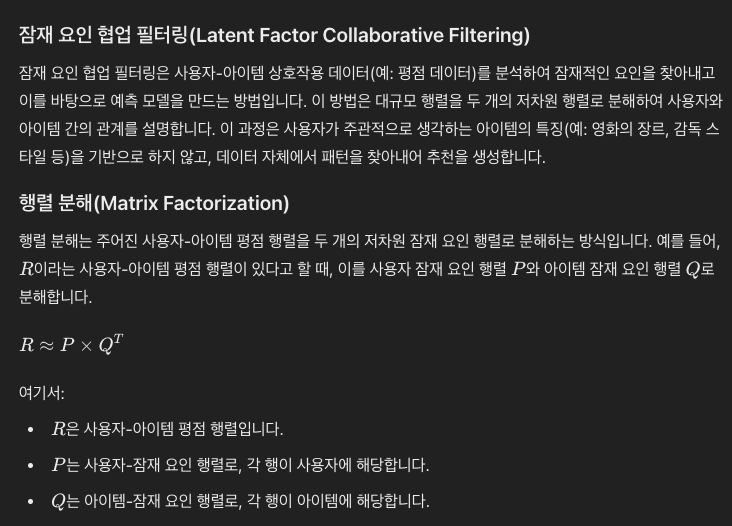

![image.png](
  
)

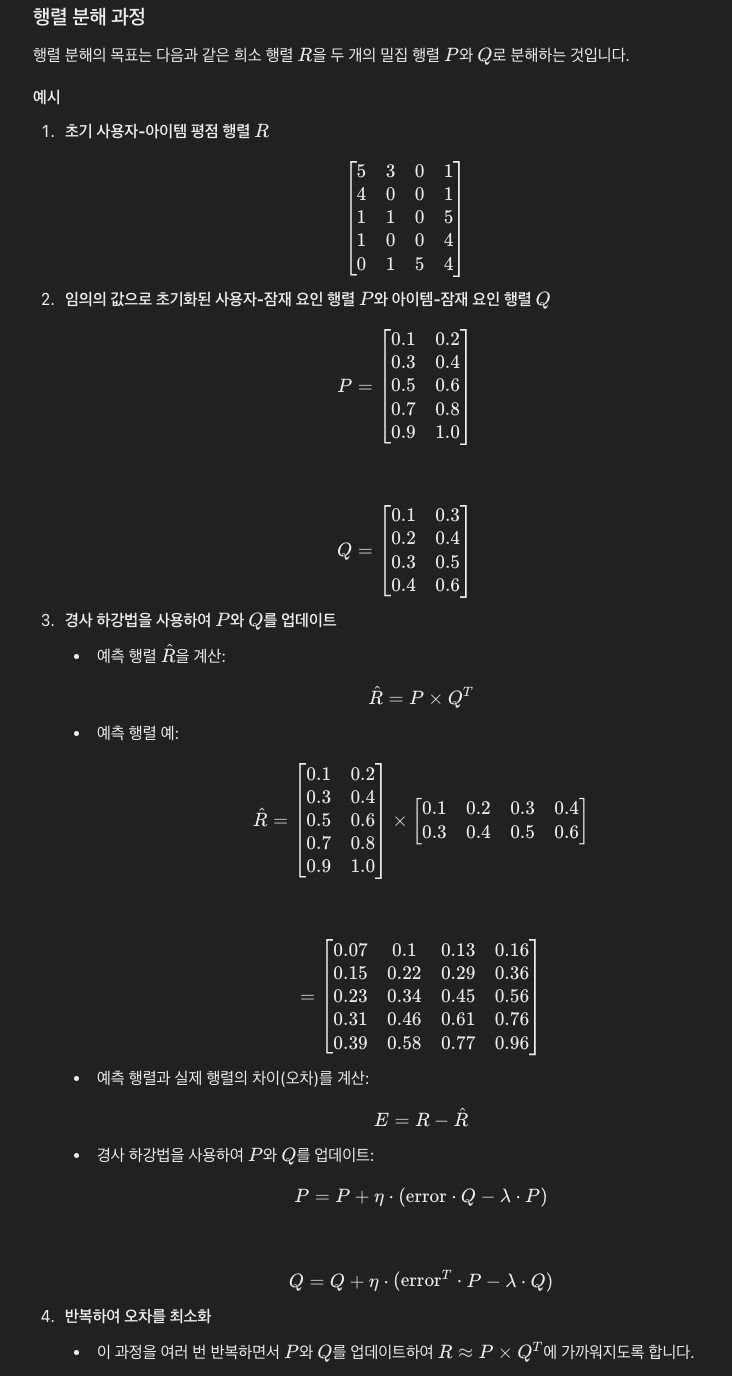

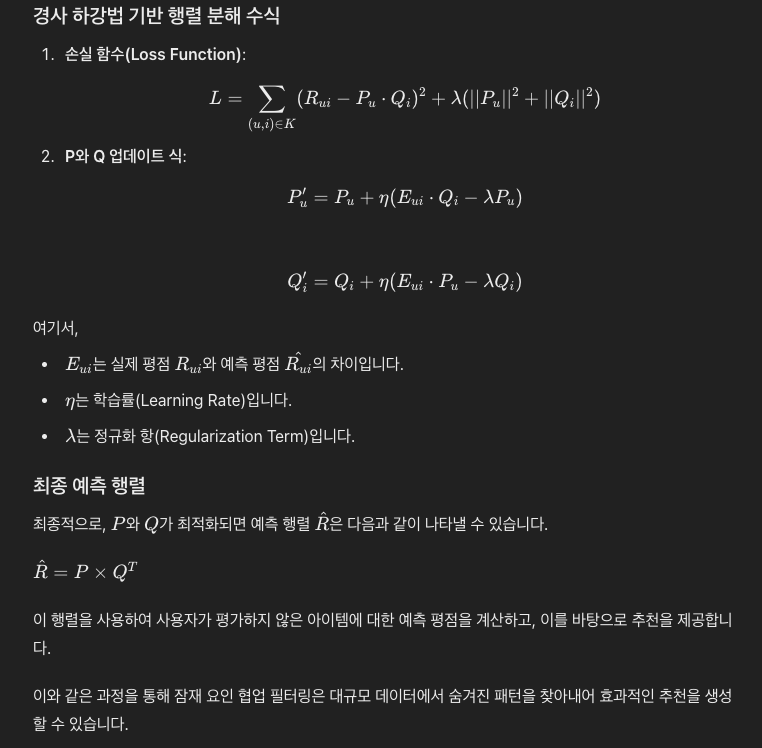

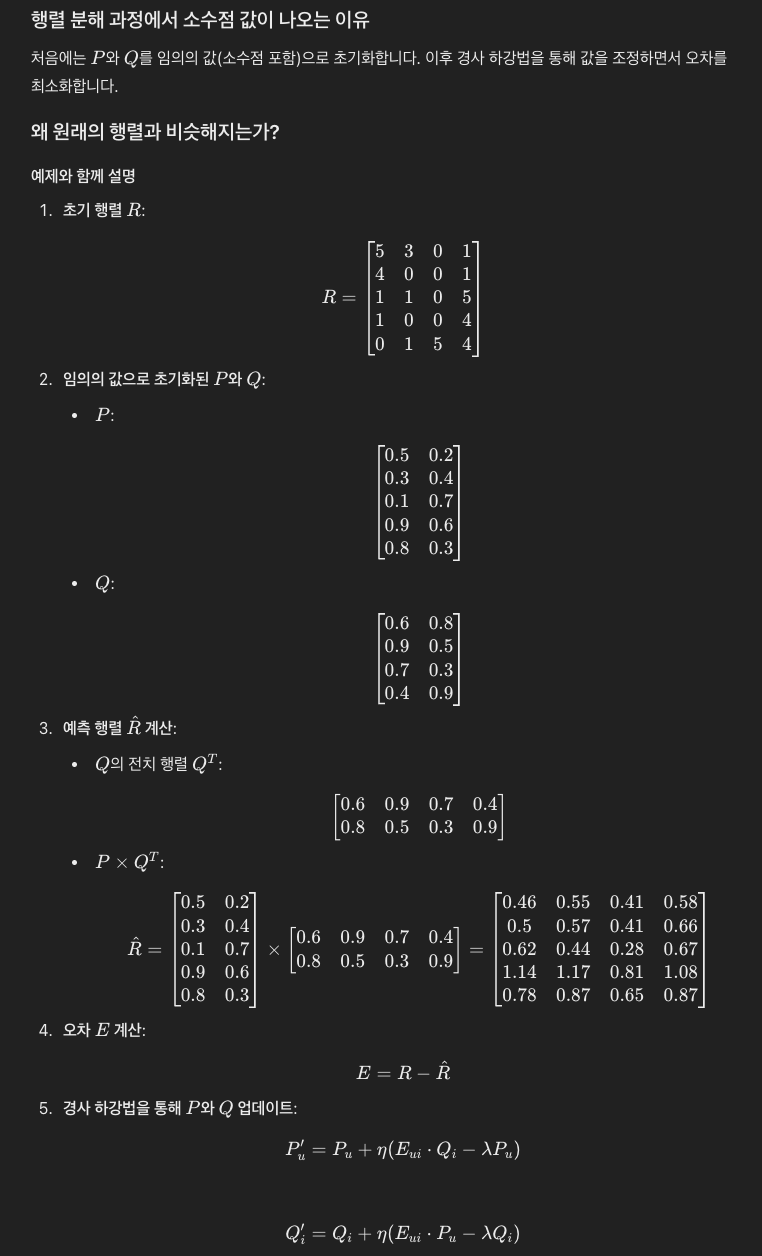

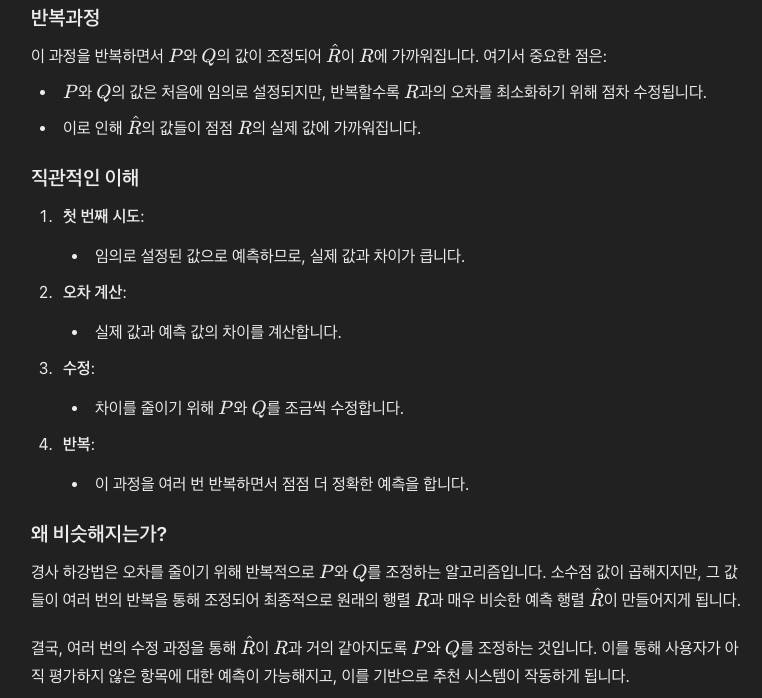

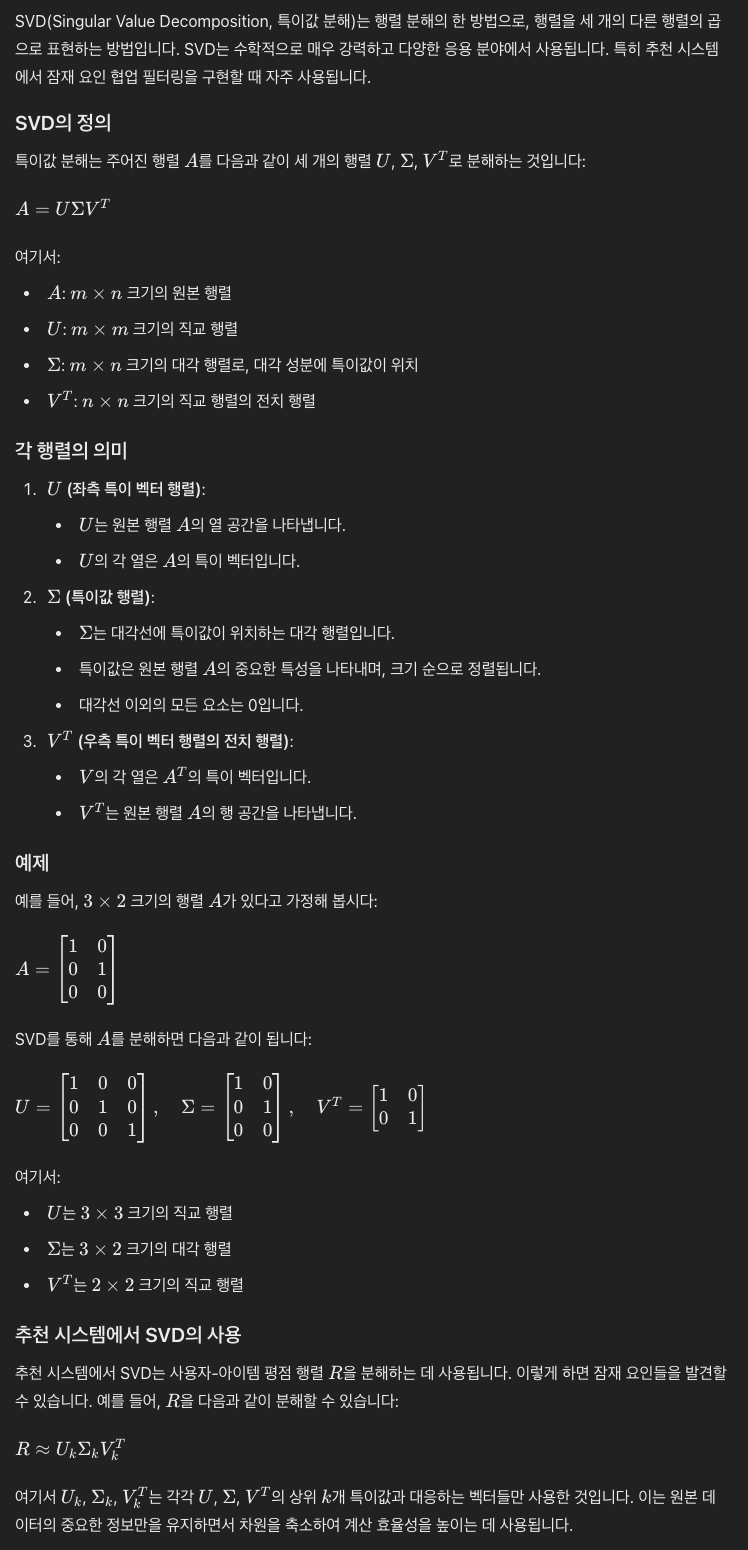

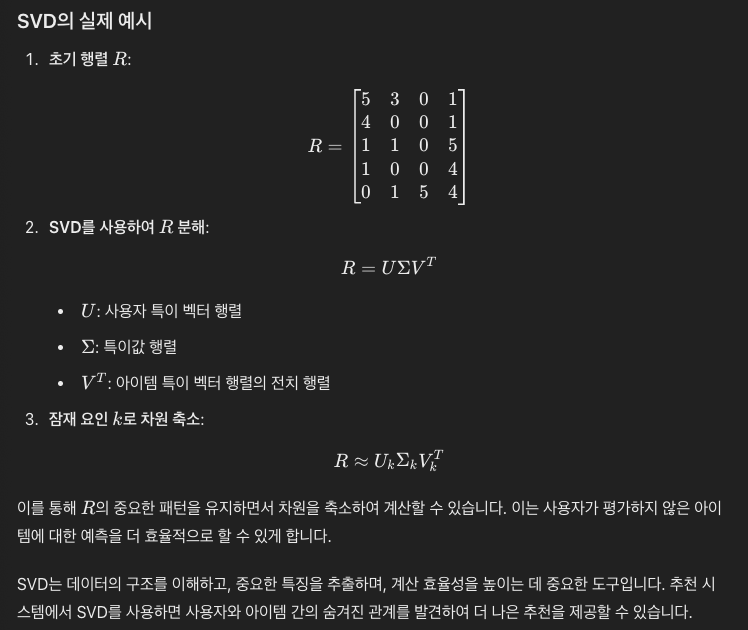

In [91]:
# from google.colab import drive
# drive.mount("/content/drive")

In [92]:
import warnings
warnings.filterwarnings('ignore')

# 경사하강법을 이용한 행렬 분해
원본 행렬 R 및 R을 분해할 P와 Q를 임의의 정규분포를 가진 랜덤값으로 초기화
$$
R=PQ^{T}
$$

In [93]:
import numpy as np

# 원본 행렬 R은 희소행렬
R = np.array([[4, np.nan, np.nan, 2, np.nan],
              [np.nan, 5, np.nan, 3, 1],
              [np.nan, np.nan, 3, 4, 4],
              [5, 2, 1, 2, np.nan]])

R

array([[ 4., nan, nan,  2., nan],
       [nan,  5., nan,  3.,  1.],
       [nan, nan,  3.,  4.,  4.],
       [ 5.,  2.,  1.,  2., nan]])

In [94]:
# 사용자의 수, 아이템의 개수를 구할 수 있음

num_users, num_items = R.shape
num_users, num_items

(4, 5)

In [95]:
# 사용할 잠재의 개수 Rank보다는 작아야 함으로 잠재요인의 개수를 일단 3으로 잡아보다

L = 3 # 잠재 (Latent)의 개수

# P와 Q 매트릭스의 크기를 지정하고, 정규 분포를 가진 Random 값으로 입력
np.random.seed(1)

P = np.random.normal(scale= 1.0 / L, size = (num_users, L))
Q = np.random.normal(scale= 1.0 / L, size = (num_items, L))

R.shape, P.shape, Q.shape

((4, 5), (4, 3), (5, 3))

# 손실 함수
분해된 행렬 P와 Q.T를 내적하여 원본 R 행렬과 똑같은 모양의 행렬을 생성하고, 실제 행렬 R에서 NaN이 아닌 위치에 있는 값만 예측 행렬의 값과 비교하여 RMSE값 계산

In [96]:
# 원본 행렬 R에서 NaN이 아닌 위치를 구하기(0이 아닌 위치) -> 좌표를 얻어낼 것임


non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]
non_zeros # -> 구해진 Target


[(0, 0, 4.0),
 (0, 3, 2.0),
 (1, 1, 5.0),
 (1, 3, 3.0),
 (1, 4, 1.0),
 (2, 2, 3.0),
 (2, 3, 4.0),
 (2, 4, 4.0),
 (3, 0, 5.0),
 (3, 1, 2.0),
 (3, 2, 1.0),
 (3, 3, 2.0)]

In [97]:
# MSE 구하기: 실제 행렬 R과 P * Q^T의 실제 값이 있던 위치에서의 오차 구하기
from sklearn.metrics import mean_squared_error


def get_rmse(R, P, Q, non_zeros):

  # 두 개의 분해된 행렬 P와 Q^T를 내적하여 예측행렬 R_pred 생성

  full_pred_matrix = (P @ Q.T) # 예측행렬

  # 실제 R 행렬에서 Nan이 아닌 값의 위치 인덱스를 추출하여 원본 R 행렬과 예측 행렬의 RMSE 계산

      # 위에서 구한 Nan이 아닌 값이 위치 좌표 담기
  x_non_zero_index = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_index = [non_zero[1] for non_zero in non_zeros]

  # 실제 행렬에서 NaN이 아닌 값
  R_non_zeros = R[x_non_zero_index, y_non_zero_index] # 타겟과 원본 값(y)

  # 실제 행렬에서 NaN이 아니었던 곳에 대한 예측 행렬에서의 예측 값
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_index, y_non_zero_index] # 타겟과 예측 값(y hat)

  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse


경사하강법에 기반하여 P와 Q의 원소들에 대한 업데이트 수행
$$
p^{\prime}_u = p_u + \eta(e_{u, i} \cdot q_i - \lambda \cdot p_u)\\
q^{\prime}_i = q_i + \eta(e_{u, i} \cdot p_u - \lambda \cdot q_i)
$$

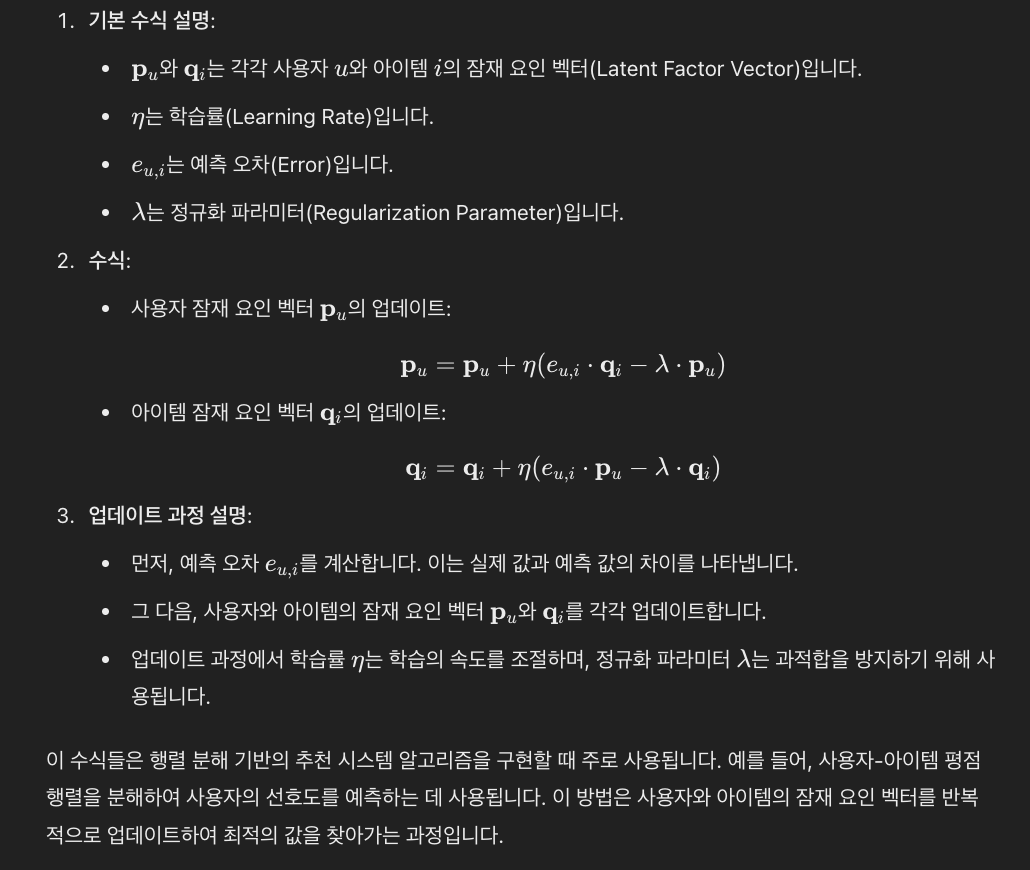

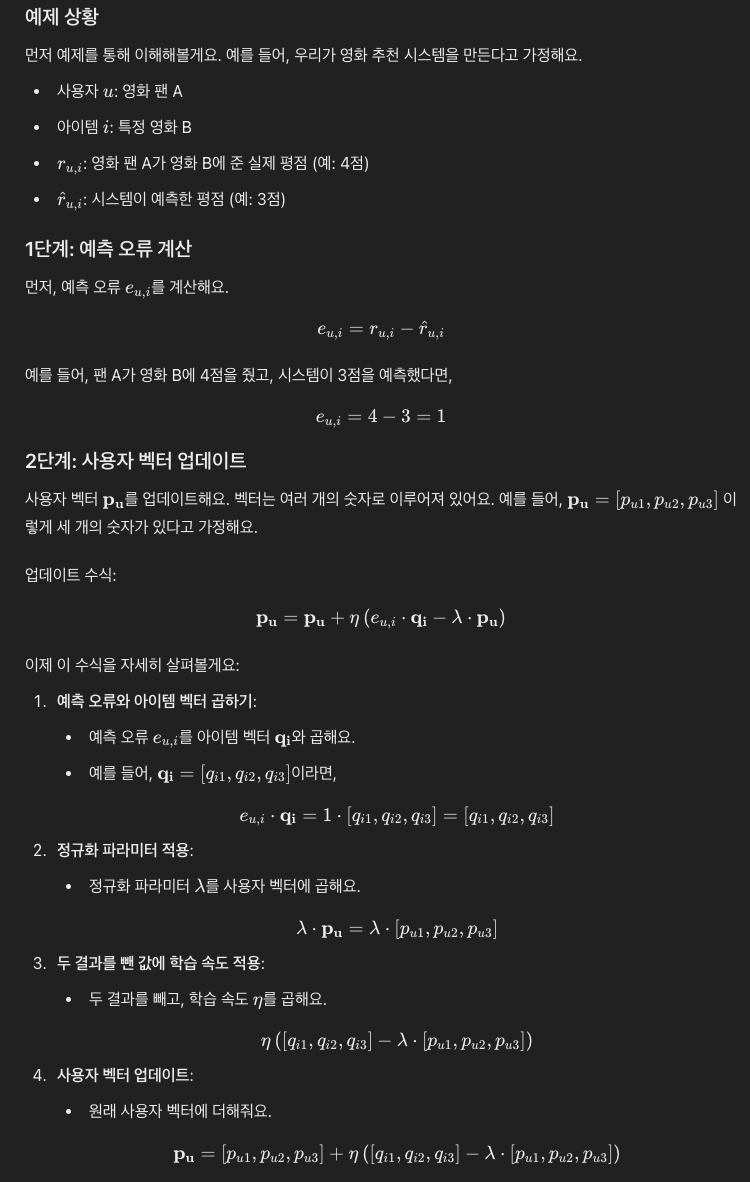

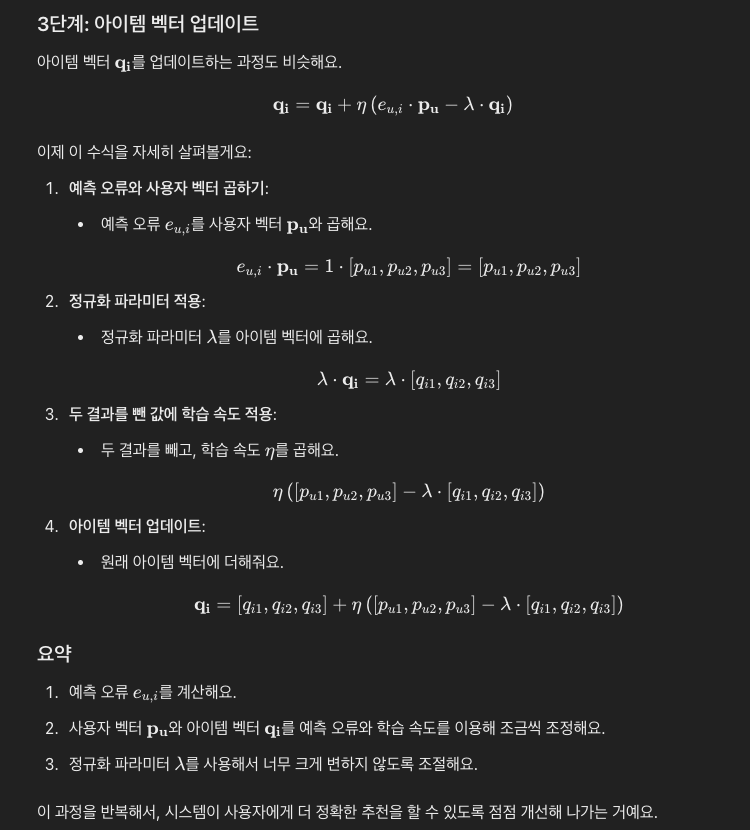

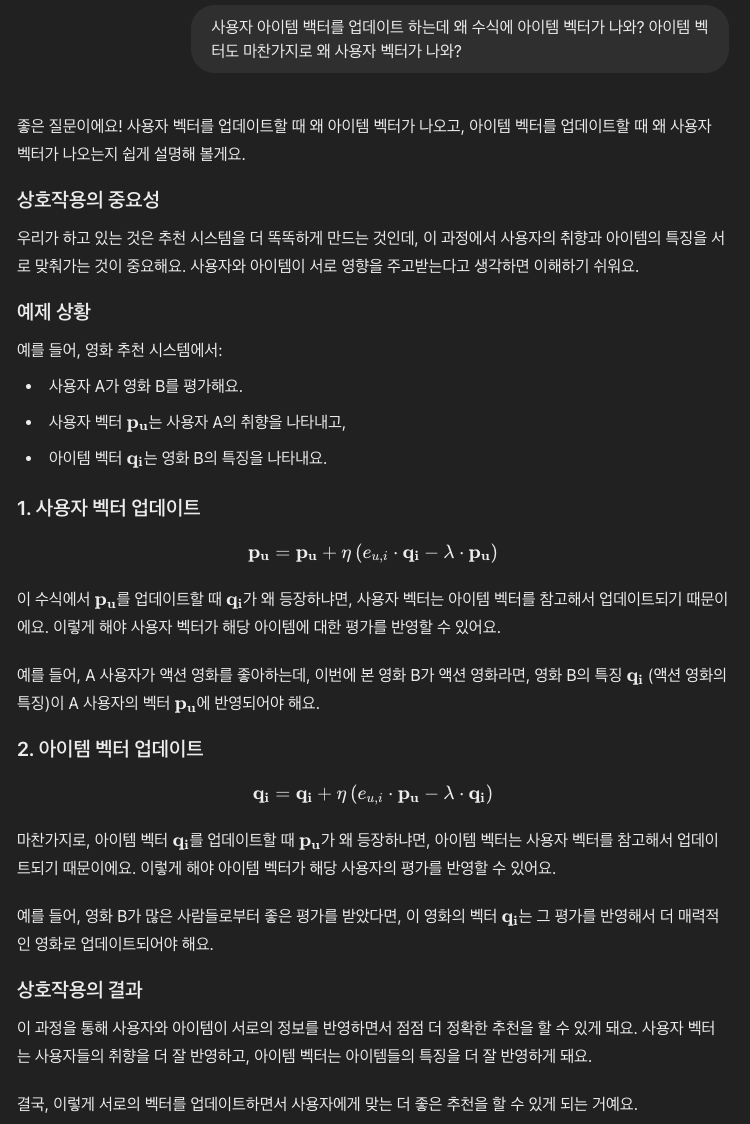

In [98]:
# 학습 횟수(경사하강법 수행 횟수), 학습률, 규제 계수 정의
steps = 1000
learning_rate = 0.01
r_lambda = 0.01 # Ridge에서의 alpha와 비슷한 역할

for step in range(steps):
  for i, j, r in non_zeros:
    # P[i, :] : i 번째 User의 모든 잠재 벡터
    # Q[j, :] : j 번째 Item의 모든 잠재 벡터
    e_ij = r - (P[i, :] @ Q[j, :].T)

    # 경사 하강법 계산. 사용자-잠재, 아이템-잠재를 업데이트
    P[i, :] = P[i, :] + learning_rate * (e_ij * Q[j, :] - r_lambda * P[i, :])
    Q[j, :] = Q[j, :] + learning_rate * (e_ij * P[i, :] - r_lambda * Q[j, :])

  rmse = get_rmse(R, P, Q, non_zeros)

  # 50회 훈련 시 마다 rmse 확인
  if ( step % 50 ) == 0:
    print("RMSE : {}".format(rmse))

RMSE : 3.2388050277987723
RMSE : 0.4876723101369647
RMSE : 0.15643403848192458
RMSE : 0.07455141311978064
RMSE : 0.043252267985793146
RMSE : 0.029248328780879226
RMSE : 0.022621116143829507
RMSE : 0.019493636196525232
RMSE : 0.018022719092132773
RMSE : 0.01731968595344283
RMSE : 0.016973657887570985
RMSE : 0.01679680459589558
RMSE : 0.016701322901884634
RMSE : 0.016644736912476574
RMSE : 0.016605910068210012
RMSE : 0.01657420047570488
RMSE : 0.01654431582921612
RMSE : 0.016513751774735037
RMSE : 0.01648146573819507
RMSE : 0.01644717168347911


In [99]:
# 훈련이 완료된 잠재 행렬을 이용해서 예측 행렬 만들기
pred_matrix = P @ Q.T

print("원본 행렬 : \n{}".format(R))
print()
print("예측 행렬 : \n{}".format(pred_matrix))

원본 행렬 : 
[[ 4. nan nan  2. nan]
 [nan  5. nan  3.  1.]
 [nan nan  3.  4.  4.]
 [ 5.  2.  1.  2. nan]]

예측 행렬 : 
[[3.99062329 0.89653623 1.30649077 2.00210666 1.66340846]
 [6.69571106 4.97792757 0.97850229 2.98066034 1.0028451 ]
 [6.67689303 0.39076095 2.98728588 3.9769208  3.98610743]
 [4.96790858 2.00517956 1.00634763 2.01691675 1.14044567]]


# 행렬 분해 기반의 잠재 요인 협업 필터링

In [100]:
# 위에서의 과정을 모두 정리해 만든 함수

def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape

    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0

    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    for step in range(steps):
        for i, j, r in non_zeros:
            e_ij = r - ( P[i, :] @ Q[j, :].T )

            P[i,:] = P[i,:] + learning_rate*(e_ij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(e_ij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [101]:
import pandas as pd
import numpy as np

MOVIE_FILE_PATH = "/Users/khb43/Desktop/HANKYUNG_WITH_TOSS_BANK(2)/week7/week7(4) python_ machine_learning(추천 시스템)/data/ml-latest-small/movies.csv"
RATING_FILE_PATH = "/Users/khb43/Desktop/HANKYUNG_WITH_TOSS_BANK(2)/week7/week7(4) python_ machine_learning(추천 시스템)/data/ml-latest-small/ratings.csv"

In [102]:
movies_df = pd.read_csv(MOVIE_FILE_PATH)
ratings_df = pd.read_csv(RATING_FILE_PATH)[['userId', "movieId", "rating"]]

ratings_matrix = ratings_df.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings_df, movies_df, on='movieId')
rating_movies.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [103]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [104]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [105]:
# columns='title' 로 title 컬럼으로 pivot 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')
ratings_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
P, Q = matrix_factorization(ratings_matrix.values, 50)


### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.29608182991810134
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.2248750327526985
### iteration step :  70  rmse :  0.20685455302331537
### iteration step :  80  rmse :  0.19413418783028683
### iteration step :  90  rmse :  0.184700820027204
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.1669518194687172
### iteration step :  130  rmse :  0.1630529219199754
### iteration step :  140  rmse :  0.1597669192967964
### iteration step :  150  rmse :  0.15695986999457318
### iteration step :  160  rmse :  0.15453398186715428
### iteration step :  170  rmse :  0.1524161855107764
### iteration step :  180  rmse :

In [107]:
# 예측 행렬
pred_matrix = P @ Q.T

ratings_pred_matrix = pd.DataFrame(data=pred_matrix,
                                index=ratings_matrix.index,
                                columns=ratings_matrix.columns)

ratings_pred_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941
4,2.628629,3.035550,2.575746,3.706912,3.430636,0.706441,3.330280,1.978826,4.560368,2.775710,...,1.046116,2.912178,2.479592,2.231915,1.888629,2.211364,0.645603,1.585734,3.542892,0.591540
5,2.116148,3.084761,2.747679,3.783490,3.946990,0.883259,1.958953,1.757317,2.054312,2.775258,...,0.956159,3.893975,2.717024,2.002443,2.053337,3.983639,2.099626,1.423718,2.490428,0.531403


In [108]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [109]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [110]:
# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 78)

# 잠재요인 기반 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 78, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shakespeare in Love (1998),5.552192
Animal House (1978),5.279583
Lawrence of Arabia (1962),4.989250
Goodfellas (1990),4.962458
Highlander (1986),4.882037
Planet of the Apes (1968),4.789879
"Santa Clause, The (1994)",4.668173
"Fifth Element, The (1997)",4.664930
Caddyshack (1980),4.644259
